In [70]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

df=pd.read_csv("SkillCraft1_Dataset.csv",encoding = "latin")
df.columns
df=df.drop('GameID', axis=1)
df = df.replace('?', np.nan) 
df[["Age","HoursPerWeek","TotalHours"]] = df[["Age","HoursPerWeek","TotalHours"]].apply(pd.to_numeric)
df = df.dropna()
df= df.reset_index(drop=True)

len(df.axes[1])


19

# Divisición del Dataset en train y test
### Dada la particularidad de que cada categoría presenta n° desbalanceado, se generó un train y un test set que respeten las proporciones originales de la muestra

In [74]:
from sklearn.model_selection import StratifiedShuffleSplit

stratified_ShuffleSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=42) 

for train_index, test_index in stratified_ShuffleSplit.split(df,df["LeagueIndex"]):
    train_set = df.loc[train_index]
    test_set = df.loc[test_index]
    
x_train = train_set.iloc[:,1:]
y_train = train_set.iloc[:,0]
x_test = test_set.iloc[:,1:]
y_test = test_set.iloc[:,0]


# Algoritmo de ML a evaluar: Árbol de decisión
### Al utilizar un Dataset enfocado en la clasificación de usuarios, para este entregable se empleo un simple arbol de decisión como algoritmo de ML para evaluar su performance.

In [76]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(x_train,y_train)



DecisionTreeClassifier()

### Debido a que se van a evluar el performance de este algoritmo con las distintas varibles que sugieran cada método de selección de variables, de antemano no se va a realizar un ajuste de los hiperparametros del algoritmo (trabajamos en principio con los valores default)

In [47]:
from sklearn.metrics import precision_score, recall_score

test_y_pred = tree_clf.predict(x_test)

precision = precision_score(y_test, test_y_pred, labels=[1,2], average='micro')
recall = recall_score(y_test, test_y_pred, average='micro')

print('Precision: %.3f' % precision)
print('Recall: %.3f' % recall)



Precision: 0.235
Recall: 0.325


# MODELO BASE
## Precision: 0.248
## Recall: 0.352

## Ajustes de hiperparametros del MODELO BASE (todas las variables) 

In [48]:
from sklearn.model_selection import GridSearchCV


param_grid = [
{'max_depth': [3, 5, 10], 'min_samples_split': [10, 20, 40, 80], "min_samples_leaf": [10, 20, 40, 80]}
]


grid_search = GridSearchCV(tree_clf, param_grid, cv=5,
scoring='accuracy',
return_train_score=True)

features_df_ = train_set.iloc[:,1:]

labels_df_=train_set.iloc[:,0]


grid_search.fit(features_df_, labels_df_)

grid_search.best_params_

{'max_depth': 5, 'min_samples_leaf': 80, 'min_samples_split': 10}

In [49]:
tree_clf_HP = DecisionTreeClassifier(max_depth=5, min_samples_leaf=80,min_samples_split=20)
tree_clf_HP.fit(x_train,y_train) 
test_y_pred = tree_clf_HP.predict(x_test)

precision = precision_score(y_test, test_y_pred, labels=[1,2], average='micro')
recall = recall_score(y_test, test_y_pred, average='micro')

print('Precision: %.3f' % precision)
print('Recall: %.3f' % recall)




Precision: 0.310
Recall: 0.380


# MODELO BASE + AJUSTE DE HIPERPARAMETROS
## Precision: 0.310 (BASE: 0.248)
## Recall: 0.352 (BASE:0.380)

# Seleccion de variables

## Métodos de filtrado: Ganancia de información

In [50]:
from sklearn.feature_selection import mutual_info_classif

df_feature = df[['Age', 'HoursPerWeek', 'TotalHours', 'APM',
       'SelectByHkeys', 'AssignToHotkeys', 'UniqueHotkeys', 'MinimapAttacks',
       'MinimapRightClicks', 'NumberOfPACs', 'GapBetweenPACs', 'ActionLatency',
       'ActionsInPAC', 'TotalMapExplored', 'WorkersMade', 'UniqueUnitsMade',
       'ComplexUnitsMade', 'ComplexAbilitiesUsed']]
df_target = df[["LeagueIndex"]]

x = df_feature.to_numpy()
y = df_target.squeeze()


mutal_info_class = mutual_info_classif(x,y)




In [51]:
mutal_info_class
df_mutual_info_class = pd.DataFrame({"mutual_info_class":mutal_info_class})

columns_features = ['Age', 'HoursPerWeek', 'TotalHours', 'APM',
       'SelectByHotkeys', 'AssignToHotkeys', 'UniqueHotkeys', 'MinimapAttacks',
       'MinimapRightClicks', 'NumberOfPACs', 'GapBetweenPACs', 'ActionLatency',
       'ActionsInPAC', 'TotalMapExplored', 'WorkersMade', 'UniqueUnitsMade',
       'ComplexUnitsMade', 'ComplexAbilitiesUsed']

df_mutual_info_class["features"] = columns_features

df_mutual_info_class = df_mutual_info_class.sort_values(['mutual_info_class'],ascending= False).reset_index(drop=True)

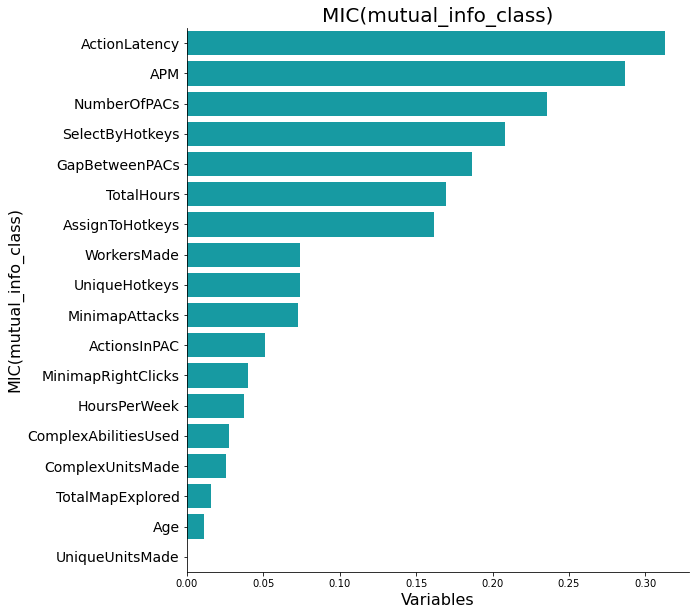

In [52]:
f, ax = plt.subplots(figsize=(9, 10))
g = sns.barplot(x="mutual_info_class", y="features", data=df_mutual_info_class,
            label="features", color="#00AFB9", order = df_mutual_info_class["features"])
g.set(xlabel='Variables', ylabel='MIC(mutual_info_class)')
sns.despine()

plt.xlabel('Variables', fontsize=16);
plt.ylabel('MIC(mutual_info_class)', fontsize=16);
plt.title('MIC(mutual_info_class)', fontsize=20)
plt.tick_params(axis='y', which='major', labelsize=14)






### Si bien no hay un valor desde el cual uno pueda decidir que variables merecen estar incluidas o no en el modelo, este gráfico muestra claramente que hay ciertas variables que disminuyen mayormente la entropía del set de datos.
* Evalúo si el modelo de desción mejora su performance tomando las 7 primeras variables.

In [53]:
train_set_MIC = train_set[["LeagueIndex","ActionLatency","APM","NumberOfPACs","SelectByHotkeys","GapBetweenPACs","AssignToHotkeys","TotalHours"]]
X_train_MIC = train_set_MIC.iloc[:,1:]
y_train_MIC = train_set_MIC.iloc[:,0]


test_set_MIC = test_set[["LeagueIndex","ActionLatency","APM","NumberOfPACs","SelectByHotkeys","GapBetweenPACs","AssignToHotkeys","TotalHours"]]
X_test_set_MIC = test_set_MIC.iloc[:,1:]
y_test_set_MIC = test_set_MIC.iloc[:,0]


tree_clf.fit(X_train_MIC,y_train_MIC) 
test_y_pred = tree_clf.predict(X_test_set_MIC)

precision = precision_score(y_test_set_MIC, test_y_pred, labels=[1,2], average='micro')
recall = recall_score(y_test, test_y_pred, average='micro')

print('Precision: %.3f' % precision)
print('Recall: %.3f' % recall)

Precision: 0.242
Recall: 0.335


## MODELO FILTRADO: GANANCIA DE INFORMACIÓN
### Precision: 0.242 (BASE: 0.248)
### Recall: 0.335 (BASE: 0.352)

## Ajustes de hiperparametros del MODELO FILTRADO: GANANCIA DE INFORMACIÓN

In [60]:
param_grid = [
{'max_depth': [3, 5, 10], 'min_samples_split': [10, 20, 40, 80], "min_samples_leaf": [10, 20, 40, 80]}
]

tree_clf = DecisionTreeClassifier()
grid_search = GridSearchCV(tree_clf, param_grid, cv=5,
scoring='accuracy',
return_train_score=True)


grid_search.fit(X_train_MIC, y_train_MIC)

grid_search.best_params_

{'max_depth': 5, 'min_samples_leaf': 20, 'min_samples_split': 80}

In [61]:
tree_clf_HP = DecisionTreeClassifier(max_depth=5, min_samples_leaf=20,min_samples_split=80)
tree_clf_HP.fit(X_train_MIC,y_train_MIC) 
test_y_pred = tree_clf_HP.predict(X_test_set_MIC)

precision = precision_score(y_test_set_MIC, test_y_pred, labels=[1,2], average='micro')
recall = recall_score(y_test, test_y_pred, average='micro')

print('Precision: %.3f' % precision)
print('Recall: %.3f' % recall)

Precision: 0.310
Recall: 0.376


## MODELO FILTRADO: GANANCIA DE INFORMACIÓN +Ajuste Hiperparametros
### Precision: 0.310 (BASE: 0.248)
### Recall: 0.386 (BASE: 0.352)


# Métodos de filtrado: FISHER SCORE

In [56]:
from skfeature.function.similarity_based import fisher_score

score_fisher = fisher_score.fisher_score(x,y)
df_score_fisher = pd.DataFrame({"fisher_score": score_fisher})
df_score_fisher["variables"] = columns_features
df_score_fisher=df_score_fisher.sort_values(["fisher_score"],ascending= False)

C:\Users\Admin\anaconda3\lib\site-packages\skfeature\utility\construct_W.py:194: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  class_idx_all = class_idx[:, np.newaxis] & class_idx[np.newaxis, :]


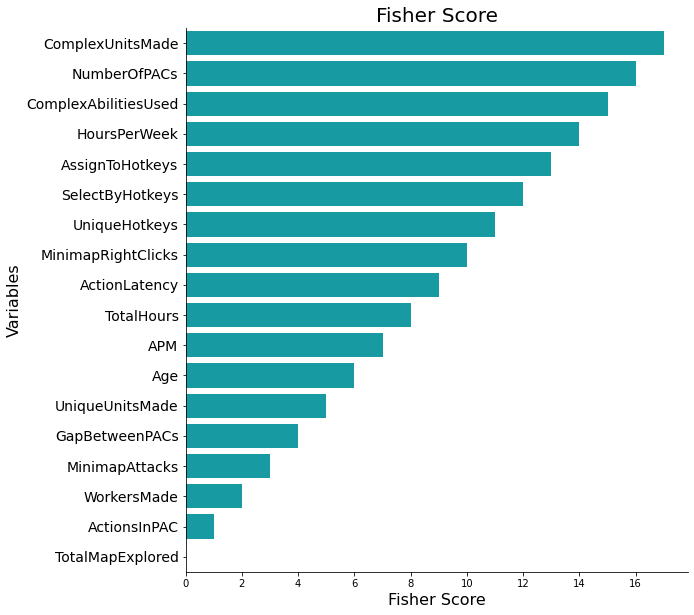

In [57]:
f, ax = plt.subplots(figsize=(9, 10))
g = sns.barplot(x="fisher_score", y="variables", data=df_score_fisher,
            label="features", color="#00AFB9",order =df_score_fisher["variables"])

sns.despine()

plt.xlabel('Fisher Score', fontsize=16);
plt.ylabel('Variables', fontsize=16);
plt.title('Fisher Score', fontsize=20)
plt.tick_params(axis='y', which='major', labelsize=14)



### Si bien ambos metodos discrepan en el orden de importancia para las diferentes varibales, hay ciertas conicidencias para algunas de ellas. Se podría unificar un criterio de selección entre ambos metodos (ej 7 primeras variables de cada metodo)

In [58]:
train_set_FISHER = train_set[["LeagueIndex","ComplexUnitsMade","NumberOfPACs","ComplexAbilitiesUsed","HoursPerWeek","AssignToHotkeys","SelectByHotkeys","UniqueHotkeys"]]
X_train_FISHER = train_set_FISHER.iloc[:,1:]
y_train_FISHER = train_set_FISHER.iloc[:,0]


test_set_FISHER = test_set[["LeagueIndex","ComplexUnitsMade","NumberOfPACs","ComplexAbilitiesUsed","HoursPerWeek","AssignToHotkeys","SelectByHotkeys","UniqueHotkeys"]]
X_test_set_FISHER = test_set_FISHER.iloc[:,1:]
y_test_set_FISHER = test_set_FISHER.iloc[:,0]


tree_clf.fit(X_train_FISHER,y_train_FISHER) 
test_y_pred = tree_clf.predict(X_test_set_FISHER)

precision = precision_score(y_test_set_FISHER, test_y_pred, labels=[1,2], average='micro')
recall = recall_score(y_test, test_y_pred, average='micro')

print('Precision: %.3f' % precision)
print('Recall: %.3f' % recall)

Precision: 0.273
Recall: 0.310


## MODELO FILTRADO: FISHER SCORE
### Precision: 0.284 (BASE: 0.248)
### Recall: 0.313 (BASE: 0.352)

## Ajustes de hiperparametros del MODELO FILTRADO: FISHER SCORE 

In [65]:
param_grid = [
{'max_depth': [3, 5, 10], 'min_samples_split': [10, 20, 40, 80], "min_samples_leaf": [10, 20, 40, 80]}
]
tree_clf = DecisionTreeClassifier()

grid_search = GridSearchCV(tree_clf, param_grid, cv=5,
scoring='accuracy',
return_train_score=True)


grid_search.fit(X_train_FISHER, y_train_FISHER)

grid_search.best_params_

{'max_depth': 5, 'min_samples_leaf': 20, 'min_samples_split': 10}

In [67]:
tree_clf_HP = DecisionTreeClassifier(max_depth=5, min_samples_leaf=20,min_samples_split=10)

tree_clf_HP.fit(X_train_FISHER,y_train_FISHER) 
test_y_pred = tree_clf_HP.predict(X_test_set_FISHER)

precision = precision_score(y_test_set_FISHER, test_y_pred, labels=[1,2], average='micro')
recall = recall_score(y_test, test_y_pred, average='micro')

print('Precision: %.3f' % precision)
print('Recall: %.3f' % recall)

Precision: 0.286
Recall: 0.358


## MODELO FILTRADO: FISHER SCORE + Ajustes Hiperparametros
### Precision: 0.286 (BASE: 0.248)
### Recall: 0.358 (BASE: 0.352)

## Métodos de filtrado: Correlación Lineal

In [13]:
corr_value = df.corr()
#Selecciono aquellas variables con un indice de pearson mayor a 0.5 y menor a -0.5 para la variable target
corr_value["LeagueIndex"]

df_corr_value = pd.DataFrame({"pearson_value": corr_value["LeagueIndex"]})
df_corr_value.reset_index(inplace = True)
df_corr_value


def seleccion_corr (df):
    if df["pearson_value"] > 0.5 or df["pearson_value"] < -0.5:
        return "ALTA"
    else:
        return "BAJA"

df_corr_value['Grado_correlacion'] = df_corr_value.apply(seleccion_corr, axis = 1)

df_corr_value = df_corr_value[df_corr_value["Grado_correlacion"] == "ALTA"]
    
print(df_corr_value)

# Analizo si las variables seleccionadas tienen alta correlacion (0.7) entre ellas, 
# y descarto aquella que tenga el menor indice de correlación de perason. 
corr_features = df[["APM","NumberOfPACs","GapBetweenPACs","ActionLatency"]].corr()
corr_features
#SELECCIONARIA BAJO ESTE CRITERIO: ActionLatency y GapBetweenPACs 


             index  pearson_value Grado_correlacion
0      LeagueIndex       1.000000              ALTA
4              APM       0.624171              ALTA
10    NumberOfPACs       0.589193              ALTA
11  GapBetweenPACs      -0.537536              ALTA
12   ActionLatency      -0.659940              ALTA


,APM,NumberOfPACs,GapBetweenPACs,ActionLatency
APM,1.000000,0.635248,-0.567396,-0.722253
NumberOfPACs,0.635248,1.000000,-0.491407,-0.817162
GapBetweenPACs,-0.567396,-0.491407,1.000000,0.680483
ActionLatency,-0.722253,-0.817162,0.680483,1.000000


In [14]:
train_set_CORR = train_set[["LeagueIndex","APM","NumberOfPACs","GapBetweenPACs","ActionLatency"]]
X_train_CORR = train_set_CORR.iloc[:,1:]
y_train_CORR = train_set_CORR.iloc[:,0]


test_set_CORR = test_set[["LeagueIndex","APM","NumberOfPACs","GapBetweenPACs","ActionLatency"]]
X_test_set_CORR = test_set_CORR.iloc[:,1:]
y_test_set_CORR = test_set_CORR.iloc[:,0]


tree_clf.fit(X_train_CORR,y_train_CORR) 
test_y_pred = tree_clf.predict(X_test_set_CORR)

precision = precision_score(y_test_set_CORR, test_y_pred, labels=[1,2], average='micro')
recall = recall_score(y_test, test_y_pred, average='micro')

print('Precision: %.3f' % precision)
print('Recall: %.3f' % recall)

Precision: 0.235
Recall: 0.289


## MODELO FILTRADO: CORRELACIÓN LINEAL
### Precision: 0.200 (BASE: 0.248)
### Recall: 0.287 (BASE: 0.352)

## Ajustes de hiperparametros del MODELO FILTRADO: CORRELACIÓN LINEAL 

In [68]:
param_grid = [
{'max_depth': [3, 5, 10], 'min_samples_split': [10, 20, 40, 80], "min_samples_leaf": [10, 20, 40, 80]}
]
tree_clf = DecisionTreeClassifier()

grid_search = GridSearchCV(tree_clf, param_grid, cv=5,
scoring='accuracy',
return_train_score=True)


grid_search.fit(X_train_CORR, y_train_CORR)

grid_search.best_params_

{'max_depth': 5, 'min_samples_leaf': 80, 'min_samples_split': 10}

In [69]:
tree_clf_HP = DecisionTreeClassifier(max_depth=5, min_samples_leaf=80,min_samples_split=10)

tree_clf_HP.fit(X_train_CORR,y_train_CORR) 
test_y_pred = tree_clf_HP.predict(X_test_set_CORR)

precision = precision_score(y_test_set_CORR, test_y_pred, labels=[1,2], average='micro')
recall = recall_score(y_test, test_y_pred, average='micro')

print('Precision: %.3f' % precision)
print('Recall: %.3f' % recall)

Precision: 0.301
Recall: 0.380


## MODELO FILTRADO: CORRELACIÓN LINEAL + Ajustes Hiperparametros
### Precision: 0.301 (BASE: 0.248)
### Recall: 0.380 (BASE: 0.352)

## Métodos Incorporados: Random Forest Importance

In [16]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators= 340)

random_forest.fit(x_train,y_train)


RandomForestClassifier(n_estimators=340)

In [23]:
importancia_variales = random_forest.feature_importances_
importancia_variales
df_importancia_variables = pd.DataFrame({"Importancia":importancia_variales, "Variables":['Age', 'HoursPerWeek', 'TotalHours', 'APM',
       'SelectByHotkeys', 'AssignToHotkeys', 'UniqueHotkeys', 'MinimapAttacks',
       'MinimapRightClicks', 'NumberOfPACs', 'GapBetweenPACs', 'ActionLatency',
       'ActionsInPAC', 'TotalMapExplored', 'WorkersMade', 'UniqueUnitsMade',
       'ComplexUnitsMade', 'ComplexAbilitiesUsed'] })
df_importancia_variables=df_importancia_variables.sort_values(by="Importancia", ascending=False)

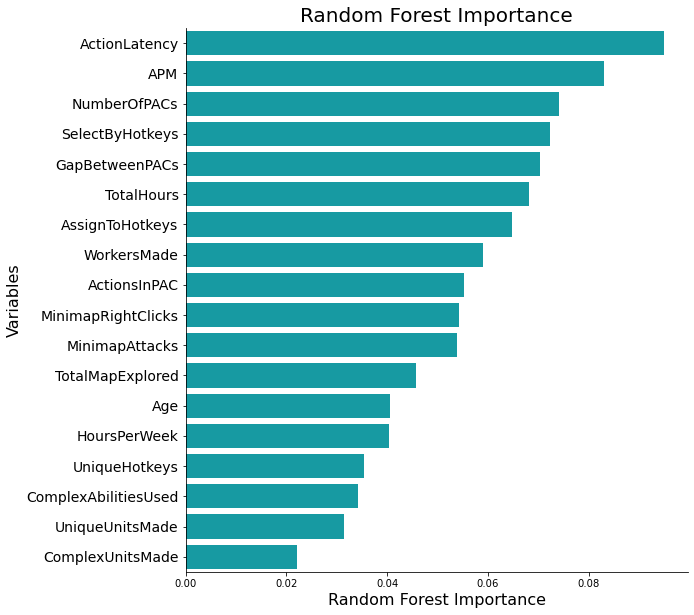

In [25]:
f, ax = plt.subplots(figsize=(9, 10))
g = sns.barplot(x="Importancia", y="Variables", data=df_importancia_variables,
            label="Variables", color="#00AFB9",order =df_importancia_variables["Variables"])

sns.despine()

plt.xlabel('Random Forest Importance', fontsize=16);
plt.ylabel('Variables', fontsize=16);
plt.title('Random Forest Importance', fontsize=20)
plt.tick_params(axis='y', which='major', labelsize=14)

## El patrón de importancia de las variables es muy similar al obtenido por MIC

In [26]:
test_y_pred = random_forest.predict(x_test)

precision = precision_score(y_test, test_y_pred, labels=[1,2], average='micro')
recall = recall_score(y_test, test_y_pred, average='micro')

print('Precision: %.3f' % precision)
print('Recall: %.3f' % recall)


Precision: 0.408
Recall: 0.436


# Selección metodos incorporados: Random Forest Importance
## Precision: 0.408 (BASE: 0.248)
## Recall: 0.436 (BASE: 0.352)

## TABLA RESUMEN
### Utilizando el mismo algoritmo de selcción (árbol de decisión)

| Metodo de selección | Ajuste de hiperparametros? | Número de variables |precision en el test set | recall en el test set | Ajuste al test set |
| --- | --- | --- | --- | --- | --- |
| Ninguno | No | 18 | 24.8 | 38.2 | Subajuste |
| Ninguno | Si | 18 | 31.0 | 35.2 | Subajuste |
| Ganancia de información | No | 7 | 24.2 | 33.5 | Subajuste |
| Ganancia de información | Si | 7 | 31.2 | 38.5 | Subajuste |
| FISHER SCORE | No | 7 | 28.4 | 31.3 | Subajuste |
| FISHER SCORE | Si | 7 | 28.6 | 35.8 | Subajuste |
| Correlación Lineal | No | 4 | 20 | 28.7 | Subajuste |
| Correlación Lineal | Si | 4 | 30.1 | 38.7 | Subajuste |
| Random Forest Importance | No | 18 | 40.8 | 43.6 | Subajuste |

# Conclusiones

### En general, los métodos de seleccion de variables de filtrado mostraron tener un precision y sensitividad cercana al 30%. A su vez, se observo que el ajuste de hiperparametros del árbol mejoro estos puntajes. El mejor metodo que mostro un mejor desempeño fue a traves de un RandomForest. 
### Por lo pronto, la reduccion o selección de variables no parece mejorar los modelos de arbol de desicion evaluados.
### Se descarta un sobreajuste de los modelos de arbol evaluados debido a que tanto la precision como la sensibilidad disminuyen cuando se los evalúa contra el TEST SET.
### Los metodos de Ensamble podrían ser los mas prometedores para la obtencion de un modelo de ML generalizable.